### Importing the relevant libraries

In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import all the necessary model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import regularizers
from tensorflow.keras.models import Model, load_model

from IPython.display import display, Image
import time

In [ ]:
# change colab flag to false if train using jupyter notebook else set to true if using colab
COLAB_FLAG = True

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [ ]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


## Import the numpy (.npz) file consisting our training images
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)

In [ ]:
INPUT_SHAPE = (224,224,3)
NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'
print(NPZ_PATH)

./drive/My Drive/4041-dog-breed-classification/Datasets/preprocessed_data_224x224.npz


In [ ]:
# check the numpy array information and the size conversion
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")

In [ ]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH)
print(loaded.files)
loaded_X = loaded["X"]
loaded_Y = loaded["Y"]
del loaded
gc.collect()

print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y']
Time taken to load compressed data: 40.00015950202942


In [ ]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X)
print()
nparray_info("Labels (npz)", loaded_Y)

Images (npz)
-  shape	 (10222, 224, 224, 3)
-  dtype	 uint8
- nbytes	 1538697216 (1.43 GB)

Labels (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [ ]:
# get the respective labels
# loading labels from csv file
df = pd.read_csv(f"{COLAB_FILEPATH}Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = sorted(df.breed.unique())
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


In [ ]:
dict_breeds

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [ ]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.title(breeds[np.where(loaded_Y[i]==1)[0][0]])
    if loaded_X.dtype==np.uint8:
        plt.imshow(loaded_X[i])
    else:
        plt.imshow(loaded_X[i].astype('float32'))

### Split data into train and validation

In [ ]:
# perform train test split to get training and validation data
X_train, X_val, y_train, y_val = train_test_split(loaded_X, loaded_Y, train_size=0.8,random_state=42)

In [ ]:
del loaded_X
del loaded_Y

### Image Augmentation

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest"
)

### Model Building

Helper Function

In [ ]:
# for plotting
def plot_model_history(history, folder=COLAB_FILEPATH+"plots/", saving_name="model_loss_accuracy"):
    plt.style.use("ggplot")
    plt.figure(figsize=(16, 6))

    # plot for loss
    ax = plt.subplot(1, 2, 1)
    # ensure ploting never plot beyond 10
    #y_max = (max(history.history["loss"]), max(history.history["val_loss"]))
    #y_max = min(10.0, max(y_max))
    #ax.set_ylim(ymax=y_max)
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot( history.history["val_loss"], label="val_loss")

    plt.title(f"Model Loss - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # plot for accuracy
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim([0,1]) # fix y-range for eazy comparison 
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")

    plt.title(f"Model Accuracy - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name+'.jpg')
    plt.show()

def plot_learning_rate(history, folder="plots/", saving_name="model_learn_rate"):
    # history only contain lr when lrScheduler used 
    #assert('lr' in history.history.keys()), "model history does not contain lr, ensure lr related callback is used"
    
    # the learning rate schedule
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 6))
    plt.plot( history.history["lr"], label="learn rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

In [ ]:
# function to train the model
def train_model(model_name,pre_trained_model,batch_size,epochs,lr,optimizer,input_shape=INPUT_SHAPE,Xtrain=X_train,Xval=X_val,ytrain=y_train,yval=y_val):
    # initialise saved weights filename
    filename = f'{model_name}_{input_shape[0]}x{input_shape[1]}_bs-{batch_size}_lr-{lr}_ep-{epochs}'

    # define callbacks
    saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}models/{filename}.h5',save_best_only=True,verbose=1)
    reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # train model
#     _, model = build_model(name)
    model = pre_trained_model
    H = model.fit(train_datagen.flow(Xtrain,ytrain,
                                    batch_size=batch_size,
                                    shuffle=True),
                  epochs=epochs,
                  steps_per_epoch=Xtrain.shape[0]//batch_size,
                  validation_data=(Xval,yval),
                  callbacks=[saved_weights, reduced_lr, early_stopping]
              )
    
    return H, filename

In [ ]:
# Load Xception - because best model from previous example
from tensorflow.keras.applications import Xception

In [ ]:
def build_model(name):
    # pre-processing layer
    input_layer = Input(INPUT_SHAPE)
    preprocessor = Lambda(lambda x: x/255.0, name="preprocessor")(input_layer)
    # pre-trained model
    if name == 'Xception':
        model = Xception(include_top=False,weights="imagenet", input_shape=INPUT_SHAPE)(preprocessor)
    else:
        raise Exception("Sorry, model not defined")

    # freeze pre-trained weight
    model.trainable = True

    # rebuild output layer
    x = model
    x = GlobalAveragePooling2D()(x)
    head = Dense(120, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=head)

    # Compiling the model
    model.compile(optimizer=OPTIMIZER, 
                  loss = 'categorical_crossentropy', 
                  metrics=['accuracy'])
    return name, model

### Training the model

In [ ]:
# hyperparameters configuration
BATCH_SIZE = 64
EPOCHS = 20
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

In [ ]:
# DenseNet121
name, model = build_model('Xception')
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
preprocessor (Lambda)        (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 21,107,360
Trainable params: 21,052,832
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
H, filename = train_model(model_name=name,
                          pre_trained_model=model,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)

Epoch 1/20
127/127 [==============================] - 220s 1s/step - loss: 2.7225 - accuracy: 0.3785 - val_loss: 2.7648 - val_accuracy: 0.3438

Epoch 00001: val_loss improved from inf to 2.76479, saving model to ./drive/My Drive/4041-dog-breed-classification/models/Xception_224x224_bs-64_lr-0.001_ep-20.h5
Epoch 2/20
127/127 [==============================] - 178s 1s/step - loss: 1.0165 - accuracy: 0.7004 - val_loss: 2.3867 - val_accuracy: 0.4103

Epoch 00002: val_loss improved from 2.76479 to 2.38672, saving model to ./drive/My Drive/4041-dog-breed-classification/models/Xception_224x224_bs-64_lr-0.001_ep-20.h5
Epoch 3/20
127/127 [==============================] - 178s 1s/step - loss: 0.6742 - accuracy: 0.7928 - val_loss: 2.3013 - val_accuracy: 0.4499

Epoch 00003: val_loss improved from 2.38672 to 2.30125, saving model to ./drive/My Drive/4041-dog-breed-classification/models/Xception_224x224_bs-64_lr-0.001_ep-20.h5
Epoch 4/20
127/127 [==============================] - 177s 1s/step - lo

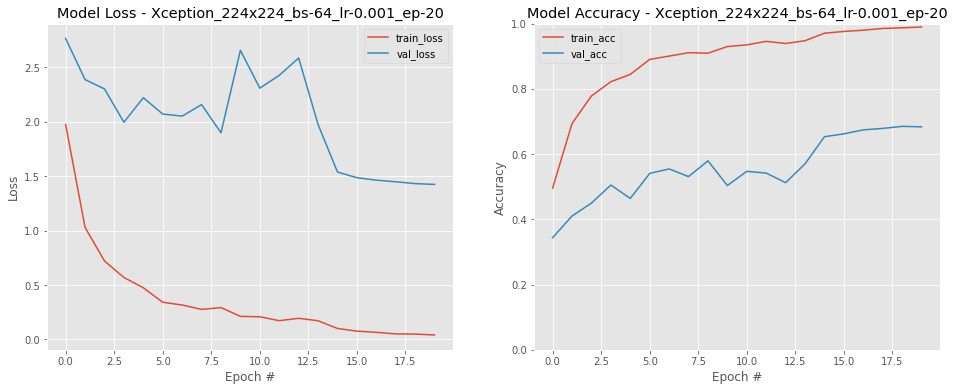

In [ ]:
# plot model performance
plot_model_history(H, saving_name=filename)